Se importan las librerias 

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 

def Armonicos (señal, tiempo, n):
    #T=len(tiempo)
    #T=tiempo[-1]
    T=len(tiempo)
    an=0
    bn=0
    a0=0
    tant=0
    for i in range (0,T,1):
        tsig=tiempo[i]
        dt=tsig-tant
        if i==0:
            a0+=(1/T) * señal[i]
        if i>0:
            an+=(2/T) * señal[i]*np.cos(n*2*np.pi*60*tiempo[i])
            bn+=(2/T) * señal[i]*np.sin(n*2*np.pi*60*tiempo[i])

    An=np.sqrt((an**2)+(bn**2))
    theta_n=np.arctan(bn/an)
    gamma_n=np.arctan(an/bn)
    tant=tiempo[i]
    return An, theta_n, gamma_n, a0

##Para obtener los datos de los puntos organizados
def get_oscilloscope(ruta):
    Dataframe=pd.read_csv(ruta)
    Dataframe=Dataframe.iloc[:, 3:5] 
    Dataframe.columns=["Tiempo", "Magnitud"]
    return Dataframe 
 
def buscaarmonicos(magnitud, tiempo):
    n=20
    armonicos=np.zeros(n)
    thetas= np.zeros(n)
    gammas=np.zeros(n)
    ft=0
    for j in range(0,n,1):
        armonicos[j] ,thetas[j], gammas[j], a0  =Armonicos(magnitud,tiempo,j)
        ft+=armonicos[j]*np.cos(j*2*np.pi*60*tiempo-thetas[j])
    ft=ft+a0
    return ft, armonicos

Carga inductiva

C:\Users\hmaur\AppData\Local\Temp\ipykernel_14028\196941722.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  gamma_n=np.arctan(an/bn)


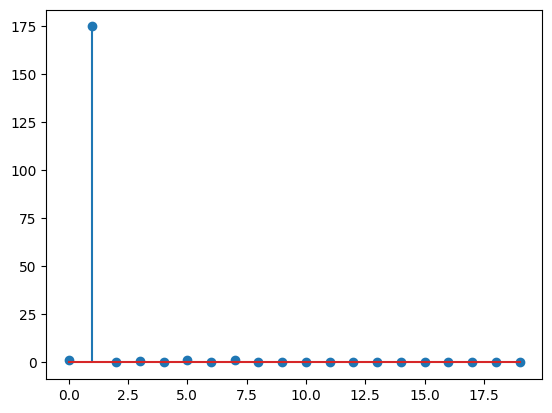

123.69755548956348

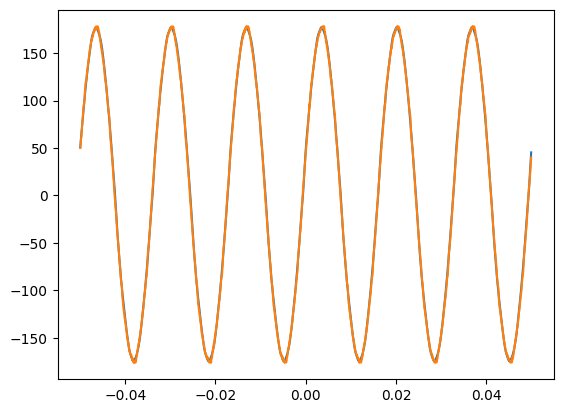

In [50]:
CH1=get_oscilloscope("abanico/CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("abanico/CH2.CSV")
R=10.4
CURRENT=(CH2.Magnitud-CH1.Magnitud)/10
ACTIVE_POWER=CURRENT*CH1.Magnitud



##Componentes armonicos

Valor_RMS=np.sqrt(np.mean(np.square(CH1.Magnitud)))
ft, armonicos =buscaarmonicos(CH1.Magnitud, CH1.Tiempo)
plt.stem(armonicos)
plt.show()
plt.plot(CH1.Tiempo,ft)
plt.plot(CH1.Tiempo,CH1.Magnitud)
Valor_RMS

## Carga no lineal

C:\Users\hmaur\AppData\Local\Temp\ipykernel_14028\196941722.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  gamma_n=np.arctan(an/bn)


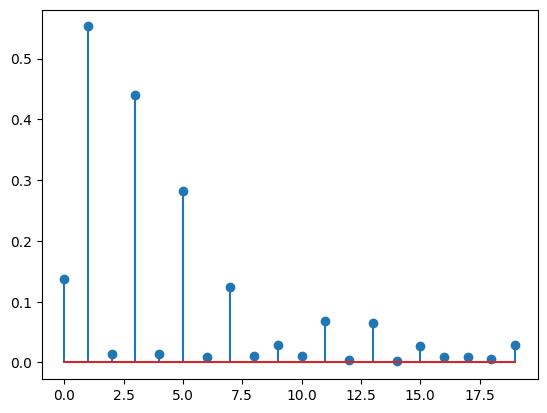

0.5638728800331835

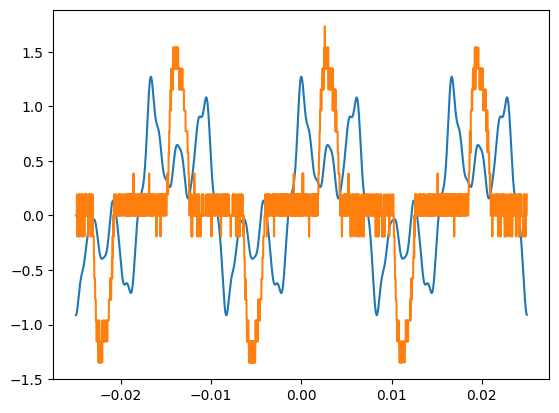

In [51]:
CH1=get_oscilloscope("PC\ALL0001\F0001CH1.CSV")#Tension en el canal 1/2
CH2=get_oscilloscope("PC\ALL0001\F0001CH2.CSV")

R=10.4
CURRENT=(CH1.Magnitud-CH2.Magnitud)/R
ACTIVE_POWER=CURRENT*CH1.Magnitud



##Componentes armonicos

Valor_RMS=np.sqrt(np.mean(np.square(CURRENT)))
ft, armonicos =buscaarmonicos(CURRENT, CH1.Tiempo)
plt.stem(armonicos)
plt.show()
plt.plot(CH1.Tiempo,ft)
plt.plot(CH1.Tiempo,CURRENT)
Valor_RMS